<a href="https://colab.research.google.com/github/Molten-Ice/3dGolfPoseEstimation/blob/colab/dev-nbs/29-end-to-end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
files_in_homedir = os.listdir('/content/')
files_in_homedir = [file for file in files_in_homedir if file not in ('.config',  'sample_data')]
input_filename = files_in_homedir[-1]
print(f"--- Your filename is the following (check this is correct before proceeding) ---\n'{input_filename}'")

os.rename(input_filename, 'input_video.mp4')

IndexError: ignored

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('input_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
!ffmpeg -ss 00:00:15 -to 00:00:19 -i input_video.mp4 -c copy output.mp4

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
### 2d inference ###

kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}
video_path = 'output.mp4'

import numpy as np
import subprocess as sp
def get_resolution(filename):
    
    """Returns height, width of video"""
    command = ['ffprobe', '-v', 'error', '-select_streams', 'v:0',
               '-show_entries', 'stream=width,height', '-of', 'csv=p=0', filename]
    with sp.Popen(command, stdout=sp.PIPE, bufsize=-1) as pipe:
        for line in pipe.stdout:
            w, h = line.decode().strip().split(',')
            return int(w), int(h)
            

def read_video(filename, skip=0, limit=-1):
    """This function reads a video file and yields each frame as a numpy array in RGB format"""
    w, h = get_resolution(filename)
    
    command = ['ffmpeg',
            '-i', filename,
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vsync', '0',
            '-vcodec', 'rawvideo', '-']
    
    i = 0
    with sp.Popen(command, stdout = sp.PIPE, bufsize=-1) as pipe:
        while True:
            data = pipe.stdout.read(w*h*3)
            if not data:
                break
            i += 1
            if i > limit and limit != -1:
                continue
            if i > skip:
                yield np.frombuffer(data, dtype='uint8').reshape((h, w, 3))

import torch
import torchvision
import torch.nn as nn
import albumentations as A # Library for augmentations
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

import os
import cv2
import json
import time
import shutil
import random
import zipfile
import argparse
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

repo_dir = "/content/"
data_path = repo_dir + "downloaded-data/"

### Setup kaggle api ###

if not os.path.exists('/root/.kaggle'): os.mkdir('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)

! chmod 600 ~/.kaggle/kaggle.json

!kaggle config set -n path -v {data_path}

## Download and unzip  models ###
dataset_name = "2dgolfmodels"
model_name = "model_1_unfrozen_fpn_rotation.pth"
! kaggle datasets download jamesdavey/{dataset_name}
zip_path = data_path+f"datasets/jamesdavey/{dataset_name}/{dataset_name}.zip"
with zipfile.ZipFile(zip_path,"r") as zip_ref:
    zip_ref.extractall(data_path)

device = 'cuda:0'
# loaded_model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
loaded_model = keypointrcnn_resnet50_fpn()
loaded_model.eval()
out = nn.ConvTranspose2d(512, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
loaded_model.roi_heads.keypoint_predictor.kps_score_lowres = out
loaded_model.load_state_dict(torch.load('downloaded-data/'+model_name))
loaded_model = loaded_model.to(device)
loaded_model.eval()
# print(list(loaded_model.backbone.fpn.parameters())[0][:5, :5, 0, 0])

class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, frames):
        self.frames = frames
        self.img_transforms = transforms.ToTensor()
        
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        img = self.frames[idx]
        target = {}
        # target["boxes"] = torch.Tensor().unsqueeze(dim=0).type(torch.FloatTensor)
        # target["labels"] = torch.Tensor(torch.ones(1)).type(torch.int64)
        # target["keypoints"] = torch.Tensor([grip + [1.], head + [1.]]).unsqueeze(dim=0).type(torch.FloatTensor)

        img = Image.fromarray(img)
        img = self.img_transforms(img)
        return img, target
    
def collate_fn(batch):
    return tuple(zip(*batch))

def generate_cords(frames):
    global keypoints
    global boxes
    dataset = GolfDataset(frames)
    dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
    print(f"Dataset lengths: {len(dataset)}| Dataloader #batches: {len(dataloader)}, batches of size {batch_size}")

    coordinates = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            preds = loaded_model([img.to(device) for img in batch[0]])
            for labels in preds:
                try:
                    grip = [int(x) for x in labels['keypoints'][0, 0, :2]]
                    head = [int(x) for x in labels['keypoints'][0, 1, :2]]
                    box = [int(x) for x in labels['boxes'][0]]
                    keypoints_for_frame = [grip, head] # don't want to save box here
                    box_for_frame = box
                except Exception as e:
                    print(f"Skipping  frame | {e}")
                    keypoints_for_frame = keypoints[-1]
                    box_for_frame = boxes[-1]
                keypoints.append(keypoints_for_frame)
                boxes.append(box_for_frame)

# Load video using ffmpeg
batch_size = 2
frames_at_once = 20
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

keypoints = []
boxes = []

frame_idx = -1
frames = []
loaded_model.eval()
for f in read_video(video_path):
    frame_idx+=1
    # if frame_idx < 192:
    #     keypoints.append([[0,0], [0,0]])
    #     boxes.append([0,0,0,0])
    #     continue
    frames.append(f)

    #split image into segments of size frames_at_once so it doesn't have to all be loaded at once
    if (len(frames) % frames_at_once == 0 and len(frames) != 0):
        print(f"Generating keypoints: {frame_idx}")
        generate_cords(frames)
        frames = []
        
if (len(frames) % frames_at_once != 0):
    print(f"Generating keypoints: {frame_idx}")
    generate_cords(frames)

np.save("club_keypoints_2d", keypoints)
# np.save("boxes", boxes)

In [ ]:
### 3d keypoints & detectron2 inference ###

## Setup
#Download VideoPose3D repo
!git clone https://github.com/facebookresearch/VideoPose3D.git
# Download pre-trained model
!wget -P VideoPose3D/checkpoint/ https://dl.fbaipublicfiles.com/video-pose-3d/pretrained_h36m_detectron_coco.bin
# Download and setup detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install ipympl

In [ ]:
!rm -rf downloaded-data

In [ ]:
import shutil 
os.makedirs('VideoPose3D/inference/videos/')
shutil.copyfile('output.mp4', 'VideoPose3D/inference/videos/output.mp4')

In [ ]:
#inferring 2D keypoints with Detectron, creatings VideoPose3D/inference/output_directory/output.mp4.npz
import os
os.mkdir("VideoPose3D/inference/output_directory")

!cd VideoPose3D/inference/ && python infer_video_d2.py \
    --cfg COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml \
    --output-dir output_directory \
    --image-ext mp4 \
    videos

In [ ]:
#Move output_directory from /inference to /data
import shutil 
shutil.move('VideoPose3D/inference/output_directory', 'VideoPose3D/data/output_directory') 

In [ ]:
#Create custom dataset VideoPose3D/data/data_2d_custom_myvideos.npz, using .npz files in VideoPose3D/data/output_directory
!cd VideoPose3D/data/ && python prepare_data_2d_custom.py -i output_directory -o myvideos

In [ ]:
#Saving output keypoints
!cd VideoPose3D/ && python run.py -d custom -k myvideos -arc 3,3,3,3,3 -c checkpoint --evaluate pretrained_h36m_detectron_coco.bin --render --viz-subject output.mp4 --viz-action custom --viz-camera 0 --viz-video inference/videos/output.mp4 --viz-export keypoints_3d --viz-size 6

In [ ]:
import shutil

shutil.move('VideoPose3D/data/data_2d_custom_myvideos.npz', 'keypoints_2d.npz')
shutil.move('VideoPose3D/keypoints_3d.npy', 'keypoints_3d.npy')

In [1]:
!wget https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/pose_estimation/output.mp4
!wget https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/pose_estimation/club_keypoints_2d.npy
!wget https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/pose_estimation/keypoints_2d.npz
!wget https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/pose_estimation/keypoints_3d.npy

--2023-05-09 19:02:18--  https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/pose_estimation/output.mp4
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/pose_estimation/output.mp4 [following]
--2023-05-09 19:02:19--  https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/pose_estimation/output.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1275371 (1.2M) [application/octet-stream]
Saving to: ‘output.mp4’

output.mp4          100%[===================>]   1.22M  --.-KB/s    in 0.06s   

2023-05-09 19:02:19 (22.0 MB/s) - ‘output.mp4’ saved 

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [30]:
import math
import numpy as np

args_viz_subject = "output.mp4"
args_viz_action = "custom"
args_viz_camera = 0
valid_pairings = np.array([[16, 10], [15, 8], [14, 6], [13, 9], [12, 7], [11, 5], [6, 15], [5, 13], [4, 11], [3, 16], [2, 14], [1, 12]])  # [10/9, 0]

# VideoPose3D keypoints -- red is right --
# [16 red wrist, 15 red elbow, 14 red shoulder, 13 black wrist, 12 black elbow, 11 black shoulder, 10 tip of head, 9 second point from head, 
# 8 middle of shoulder, 7 stomach, 6 black foot, 5 black knee, 4 black hip, 3 red foot, 2 red knee, 1 red hip, 0 middle of thighs
# detectron keypoints
# "keypoints": [ 0"nose", 1"left_eye", 2"right_eye", 3"left_ear", 4"right_ear", 5"left_shoulder",
# 6"right_shoulder", 7"left_elbow", 8"right_elbow", 9"left_wrist", 10"right_wrist", 11"left_hip",
# 12"right_hip", 13"left_knee", 14"right_knee", 15"left_ankle", 16"right_ankle" ]

print('Loading 2D detections...')
keypoints = np.load('keypoints_2d.npz', allow_pickle=True)
keypoints_metadata = keypoints['metadata'].item()
keypoints_symmetry = keypoints_metadata['keypoints_symmetry']
kps_left, kps_right = list(keypoints_symmetry[0]), list(keypoints_symmetry[1])
# joints_left, joints_right = list(dataset.skeleton().joints_left()), list(dataset.skeleton().joints_right())
joints_left, joints_right = [4, 5, 6, 11, 12, 13], [1, 2, 3, 14, 15, 16]
skeleton_parents = [-1,  0,  1,  2,  0,  4,  5,  0,  7,  8,  9,  8, 11, 12,  8, 14, 15]
keypoints = keypoints['positions_2d'].item()[args_viz_subject][args_viz_action][args_viz_camera]


print('Loading 3D detections...')
poses = np.load('keypoints_3d.npy')

print('Loading 2D club...')
club_keypoints_2d = np.load('club_keypoints_2d.npy')

keypoints[0, :2], poses[0, :2], club_keypoints_2d[0]

Loading 2D detections...
Loading 3D detections...
Loading 2D club...


(array([[636.01965, 240.7209 ],
        [637.93994, 230.172  ]], dtype=float32),
 array([[ 3.0070642e-06, -2.2334632e-05,  3.4110417e-06],
        [-1.7087556e-02,  2.4511794e-02, -1.2118627e-01]], dtype=float32),
 array([[606, 439],
        [823, 631]]))

In [31]:
### Helper functions ###
import math
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import subprocess as sp

def find_median_sf(poses, keypoints):
    scale_factors = []
    for i in range(len(poses)):

        pos_unscaled = poses[i].copy()
        frame_2d_keypoints = keypoints[i].copy()

        known_3d = pos_unscaled[valid_pairings[:, 0]]
        differences = []
        for idx in range(len(known_3d)):
            differences.append(np.linalg.norm(known_3d - known_3d[idx], axis=1).mean())
        factor_3d = np.sort(differences)[len(differences)//2]

        known_2d = frame_2d_keypoints[valid_pairings[:, 1]]
        differences = []
        for idx in range(len(known_2d)):
            differences.append(np.linalg.norm(known_2d - known_2d[idx], axis=1).mean())
        factor_2d = np.sort(differences)[len(differences)//2]

        sf = factor_2d/factor_3d
        scale_factors.append(sf)
    scale_factors = np.sort(scale_factors)
    return scale_factors[len(scale_factors)//2]

def align_3d_skeleton(pos, frame_2d_keypoints, sf, print_difference = False):

    pos = pos_unscaled*sf
    translations_differences = (frame_2d_keypoints[valid_pairings[:, 1]] - pos[valid_pairings[:, 0], :2])
    x_translation = np.sort(translations_differences[:, 0])[len(translations_differences)//2]
    y_translation = np.sort(translations_differences[:, 1])[len(translations_differences)//2]
    translation = [x_translation, y_translation]
    pos[:, :2] = pos[:, :2] + translation

    if print_difference:
        differences = pos[valid_pairings[:, 0], :2] -  frame_2d_keypoints[valid_pairings[:, 1]]
        print(f"{i} | Average difference: {abs(differences).mean():.2f} | translation: {translation} | sf: {sf:.2f} | factor 2d: {factor_2d:.2f} | factor 3d: {factor_3d:.4f}")

    return pos

def sphere_z_values(x, y, center, radius):
    x0, y0, z0 = center
    r_squared = radius ** 2

    # Calculate the term inside the square root
    term = r_squared - (x - x0) ** 2 - (y - y0) ** 2

    # Check if the term is non-negative, as square root of a negative number is not real
    if term >= 0:
        sqrt_term = term ** 0.5
        z1 = z0 + sqrt_term
        z2 = z0 - sqrt_term
        return z1, z2
    else:
        return None

def get_resolution(filename):
    """Returns height, width of video"""
    command = ['ffprobe', '-v', 'error', '-select_streams', 'v:0',
               '-show_entries', 'stream=width,height', '-of', 'csv=p=0', filename]
    with sp.Popen(command, stdout=sp.PIPE, bufsize=-1) as pipe:
        for line in pipe.stdout:
            w, h = line.decode().strip().split(',')
            return int(w), int(h)
            
def get_fps(filename):
    """Returns the fps of the video"""
    command = ['ffprobe', '-v', 'error', '-select_streams', 'v:0',
               '-show_entries', 'stream=r_frame_rate', '-of', 'csv=p=0', filename]
    with sp.Popen(command, stdout=sp.PIPE, bufsize=-1) as pipe:
        for line in pipe.stdout:
            a, b = line.decode().strip().split('/')
            return int(a) / int(b)

def read_video(filename, skip=0, limit=-1):
    """This function reads a video file and yields each frame as a numpy array in RGB format"""
    w, h = get_resolution(filename)
    
    command = ['ffmpeg',
            '-i', filename,
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vsync', '0',
            '-vcodec', 'rawvideo', '-']
    
    i = 0
    with sp.Popen(command, stdout = sp.PIPE, bufsize=-1) as pipe:
        while True:
            data = pipe.stdout.read(w*h*3)
            if not data:
                break
            i += 1
            if i > limit and limit != -1:
                continue
            if i > skip:
                yield np.frombuffer(data, dtype='uint8').reshape((h, w, 3))

In [32]:
# VideoPose3D keypoints -- red is right --
# [16 red wrist, 15 red elbow, 14 red shoulder, 13 black wrist, 12 black elbow, 11 black shoulder, 10 tip of head, 9 second point from head, 
# 8 middle of shoulder, 7 stomach, 6 black foot, 5 black knee, 4 black hip, 3 red foot, 2 red knee, 1 red hip, 0 middle of thighs
# detectron keypoints
# "keypoints": [ 0"nose", 1"left_eye", 2"right_eye", 3"left_ear", 4"right_ear", 5"left_shoulder",
# 6"right_shoulder", 7"left_elbow", 8"right_elbow", 9"left_wrist", 10"right_wrist", 11"left_hip",
# 12"right_hip", 13"left_knee", 14"right_knee", 15"left_ankle", 16"right_ankle" ]

In [33]:
club_lengths_2d = sorted([np.linalg.norm(club[0] - club[1]) for club in club_keypoints_2d])
radius = club_lengths_2d[-5] * 1 #orthogonal_factor
sf = find_median_sf(poses, keypoints)
print(f"Radius = {radius:.3f} | sf {sf:.3f}")
adjusted_poses = []
club_coordinates = []

head = [0, 0, 0] # deals with case where it can't spot something in first few frames
for i in range(len(poses)):
    pos_unscaled = poses[i].copy()
    frame_2d_keypoints = keypoints[i].copy()
    frame_club_2d_keypoints = club_keypoints_2d[i].copy()
    pos = align_3d_skeleton(pos_unscaled, frame_2d_keypoints, sf, print_difference = False)
    adjusted_poses.append(pos)

    average_wrist_x, average_wrist_y, average_wrist_z =  pos[[13, 16]].mean(axis=0)
    grip = np.array(list(frame_club_2d_keypoints[0]) + [average_wrist_z]) #use detectron2 x,y cords for 3d grip

    z_values = sphere_z_values(*frame_club_2d_keypoints[1], grip, radius)
    if z_values is not None:
        head = list(frame_club_2d_keypoints[1]) + [max(z_values)]
    
    grip_new = np.array([average_wrist_x, average_wrist_y, average_wrist_z])
    adjusted_club = np.array([grip, head])

    translation_vector = grip_new - grip
    adjusted_club=  adjusted_club + translation_vector

    club_coordinates.append(adjusted_club)

adjusted_poses = np.array(adjusted_poses)
club_coordinates = np.array(club_coordinates)

Radius = 301.891 | sf 290.983


In [34]:
min_max_values = []
for dim in range(3):
    body_min_value, body_max_value = np.sort([x.min() for x in adjusted_poses[..., dim]])[5], np.sort([x.max() for x in adjusted_poses[..., dim]])[-5]
    club_min_value, club_max_value = np.sort([x.min() for x in club_coordinates[..., dim]])[5], np.sort([x.max() for x in club_coordinates[..., dim]])[-5]
    min_value = min(body_min_value, club_min_value)
    max_value = max(body_max_value, club_max_value)
    min_max_values.append([min_value, max_value])
min_max_values = np.array(min_max_values)
print("min_max values", min_max_values)

min_max values [[369.60510254 821.60467529]
 [105.49035645 633.9967041 ]
 [-86.21200562 293.22724063]]


In [35]:
# !rm -rf frames
import os
if not os.path.exists('frames'):
    os.makedirs('frames')

# %matplotlib inline
i = 0 #frame number
size = 6

# Load video using ffmpeg
for f in read_video('output.mp4', skip = i):
    frame = f

    pos = adjusted_poses[i].copy()
    frame_2d_keypoints = keypoints[i].copy()
    frame_club_2d_keypoints = club_keypoints_2d[i].copy()
    club_3d_keypoints = club_coordinates[i].copy()

    # plt.clf() 
    fig = plt.figure(figsize=(2*size, size)) # 6x6

    ax_in = fig.add_subplot(1, 2, 1)
    ax_in.get_xaxis().set_visible(False)
    ax_in.get_yaxis().set_visible(False)
    # ax_in.set_xlabel('X')
    # ax_in.set_ylabel('Y')
    ax_in.set_axis_off()
    ax_in.set_title('Input')

    ax = fig.add_subplot(1, 2, 2, projection='3d')

    ax.set_xlim3d(min_max_values[0])
    ax.set_ylim3d(min_max_values[1])
    ax.set_zlim3d(min_max_values[2])

    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    # ax.set_xlabel('X')
    # ax.set_ylabel('Y')
    # ax.set_zlabel('Z')
    ax.set_title("Reconstruction")

    # Update 2D poses
    joints_right_2d = keypoints_symmetry[1]
    colors_2d = np.full(keypoints.shape[1], 'black')
    colors_2d[joints_right_2d] = 'red'
    image = ax_in.imshow(frame, aspect='equal')

    for j, j_parent in enumerate(skeleton_parents):
        if j_parent == -1:
            continue
            
        col = 'red' if j in joints_right else 'black'
        
        ax.plot([pos[j, 0], pos[j_parent, 0]],
                    [pos[j, 1], pos[j_parent, 1]],
                    [pos[j, 2], pos[j_parent, 2]], zdir='z', c=col)


    #plot points which show on both
    #3d points which have a bijection to 2d points
    # ax.scatter(*pos[valid_pairings[:, 0]].T, color = ['red', 'red', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'red', 'red'])
    #projected 3d to 2d keypoints
    # ax_in.scatter(*pos[valid_pairings[:, 0]][:, :2].T, 10, color=colors_2d[valid_pairings[:, 1]], edgecolors='fuchsia', zorder=10)

    #2d keypoints (from detectron2) to display
    # ax_in.scatter(*frame_2d_keypoints.T, 10, color=colors_2d, edgecolors='white', zorder=10)
    ax_in.scatter(*frame_2d_keypoints[valid_pairings[:, 1]].T, 10, color=colors_2d[valid_pairings[:, 1]], edgecolors='white', zorder=10)

    # #Plotting club:
    # grip, head = club_3d_keypoints

    # projected 3d coordinates
    # ax_in.scatter(*club_3d_keypoints[:, :2].T, 10, color='blue', edgecolors='white', zorder=10)
    # ax_in.plot(*club_3d_keypoints[:, :2].T, linestyle = 'dashed', color = 'white')
    ax_in.scatter(*frame_club_2d_keypoints.T, 10, color='blue', edgecolors='white', zorder=10)
    ax_in.plot(*frame_club_2d_keypoints.T, linestyle = 'dashed', color = 'white')
    
    ax.scatter(*club_3d_keypoints.T, zdir='z', color='blue', edgecolors='white', zorder=10)
    ax.plot(*club_3d_keypoints.T, zdir='z', c = 'blue')

    ax.view_init(elev=90., azim=90) # Note Y axis increases as it goes down on image so need to rotate 3d plot
    ax.invert_xaxis()
    plt.subplots_adjust(wspace=0.4)
    # break
    plt.savefig(f'frames/{i}.jpg')
    plt.close()
    print(f"Saved frame: {i}")
    i += 1

# %matplotlib inline
# plt.show()

Saved frame: 0
Saved frame: 1
Saved frame: 2
Saved frame: 3
Saved frame: 4
Saved frame: 5
Saved frame: 6
Saved frame: 7
Saved frame: 8
Saved frame: 9
Saved frame: 10
Saved frame: 11
Saved frame: 12
Saved frame: 13
Saved frame: 14
Saved frame: 15
Saved frame: 16
Saved frame: 17
Saved frame: 18
Saved frame: 19
Saved frame: 20
Saved frame: 21
Saved frame: 22
Saved frame: 23
Saved frame: 24
Saved frame: 25
Saved frame: 26
Saved frame: 27
Saved frame: 28
Saved frame: 29
Saved frame: 30
Saved frame: 31
Saved frame: 32
Saved frame: 33
Saved frame: 34
Saved frame: 35
Saved frame: 36
Saved frame: 37
Saved frame: 38
Saved frame: 39
Saved frame: 40
Saved frame: 41
Saved frame: 42
Saved frame: 43
Saved frame: 44
Saved frame: 45
Saved frame: 46
Saved frame: 47
Saved frame: 48
Saved frame: 49
Saved frame: 50
Saved frame: 51
Saved frame: 52
Saved frame: 53
Saved frame: 54
Saved frame: 55
Saved frame: 56
Saved frame: 57
Saved frame: 58
Saved frame: 59
Saved frame: 60
Saved frame: 61
Saved frame: 62
Sa

In [36]:
!pip install ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!cd frames && ffmpeg -start_number 0 -framerate 5 -i %d.jpg \
  -c:v libx264 -pix_fmt yuv420p golf_3d_pose_estimation.mp4

!mv frames/golf_3d_pose_estimation.mp4 golf_3d_pose_estimation.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [38]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('golf_3d_pose_estimation.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Radius = 301.891 | sf 290.982666
No real z solutions for i=57
No real z solutions for i=58
No real z solutions for i=73
No real z solutions for i=89


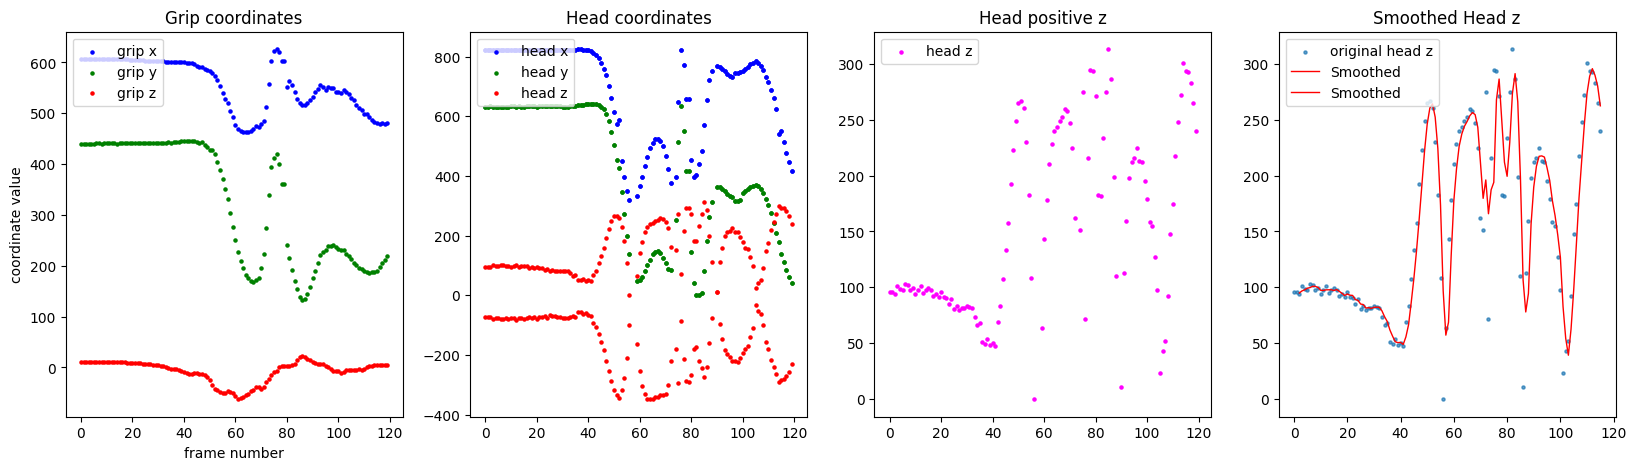

In [ ]:
sf = find_median_sf(poses, keypoints)
print(f"Radius = {radius:.3f} | sf {sf:3f}")
grip_coordinates = []
possible_head_coordinates = []
closer_z_coordinates = []

for i in range(len(poses)):
    pos_unscaled = poses[i].copy()
    frame_2d_keypoints = keypoints[i].copy()
    frame_club_2d_keypoints = club_keypoints_2d[i].copy()

    pos = align_3d_skeleton(pos_unscaled, frame_2d_keypoints, sf)

    average_wrist_z = pos[[13, 16], 2].mean()
    grip = np.array(list(frame_club_2d_keypoints[0]) + [average_wrist_z])
    grip_coordinates.append(grip)

    z_values = sphere_z_values(*frame_club_2d_keypoints[1], grip, radius)
    if z_values is not None:
        possible_head_coordinates.append([i, list(frame_club_2d_keypoints[1]) + [z_values[0]]])
        possible_head_coordinates.append([i, list(frame_club_2d_keypoints[1]) + [z_values[1]]])
        closer_z_coordinates.append([i, list(frame_club_2d_keypoints[1]) + [max(z_values)]])
    else:
        print(f"No real z solutions for i={i}")

import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 5))

grip_coordinates = np.array(grip_coordinates)
ax0.scatter(list(range(len(grip_coordinates))), grip_coordinates[:, 0], marker='o', color='blue', label='grip x', s = 5)
ax0.scatter(list(range(len(grip_coordinates))), grip_coordinates[:, 1], marker='o', color='green', label='grip y', s = 5)
ax0.scatter(list(range(len(grip_coordinates))), grip_coordinates[:, 2], marker='o', color='red', label='grip z', s = 5)


ax1.scatter([x[0] for x in possible_head_coordinates], [x[1][0] for x in possible_head_coordinates], marker='o', color='blue', label='head x', s = 5)
ax1.scatter([x[0] for x in possible_head_coordinates], [x[1][1] for x in possible_head_coordinates], marker='o', color='green', label='head y', s = 5)
ax1.scatter([x[0] for x in possible_head_coordinates], [x[1][2] for x in possible_head_coordinates], marker='o', color='red', label='head z', s = 5)

ax2.scatter([x[0] for x in closer_z_coordinates], [x[1][2] for x in closer_z_coordinates], marker='o', color='fuchsia', label='head z', s = 5)

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Sample data (replace this with your list of values)
data = [x[1][2] for x in closer_z_coordinates]

# Set the window size for the moving average
window_size = 3
# Smooth the data using the moving average function
smoothed_data = moving_average(data, window_size)
# Plot both the original and smoothed data
x_smoothed = np.arange(window_size - 1, len(data))

ax3.scatter(np.arange(len(data)), data, label='original head z', marker='o', alpha=0.7, s = 5)
ax3.plot(x_smoothed, smoothed_data, 1, label='Smoothed', linewidth=1, color = 'red')

ax0.set_xlabel('frame number')
ax0.set_ylabel('coordinate value')

# Add title and axis labels
for ax, title in zip([ax0, ax1, ax2, ax3], ['Grip coordinates', 'Head coordinates', 'Head positive z', 'Smoothed Head z']):
    ax.set_title(title)
    ax.legend(loc="upper left")

plt.show()